In [1]:
import pandas as pd
import re
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)
from keras.utils import np_utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# DM reduce methods compare



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', categories=["talk.politics.guns",'alt.atheism', 'sci.space']) 
#newsgroups_test = fetch_20newsgroups(subset='test', categories=["talk.politics.guns",'alt.atheism', 'sci.space'])
#newsgroups_train = fetch_20newsgroups(subset='train') 
num_cluster=3

In [3]:
newsgroups_df=pd.DataFrame(newsgroups_train.data)
newsgroups_df["clean.text"] = newsgroups_df[0].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z\- \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in nltk.word_tokenize(x) if not i in swords])\
          .apply(lambda x: [SnowballStemmer("english").stem(i) for i in x]
                 )
newsgroups_df["clean.text"]=newsgroups_df["clean.text"].astype(str).tolist()

## TFIDF

In [4]:
tfidf_vectorizer = TfidfVectorizer( 
                                  min_df=5,
                                  stop_words='english',
                                  lowercase=False,
                                  )


In [5]:
news_train = tfidf_vectorizer.fit_transform(newsgroups_df["clean.text"])
news_train.shape

(1619, 5456)

In [6]:
kmeans = KMeans(n_clusters = num_cluster,random_state=123).fit(news_train)
score = calinski_harabasz_score(news_train.toarray(),kmeans.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(news_train.toarray(),kmeans.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(news_train.toarray(),kmeans.labels_)
print('Davies-Bouldin Index:',score)


calinski_harabaz：16.072274
silhouette：0.010639
Davies-Bouldin Index: 7.943420641201044


### SVD

In [ ]:
svd_word = TruncatedSVD(n_components=2)
svd_news_train = svd_word.fit_transform(news_train)
svd_news_train.shape

(1619, 2)

In [ ]:
kmeans = KMeans(n_clusters = num_cluster,random_state=123).fit(svd_news_train)
score = calinski_harabasz_score(svd_news_train,kmeans.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(svd_news_train,kmeans.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(svd_news_train,kmeans.labels_)
print('Davies-Bouldin Index:',score)

calinski_harabaz：1663.516937
silhouette：0.423778
Davies-Bouldin Index: 0.8037675771935805


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


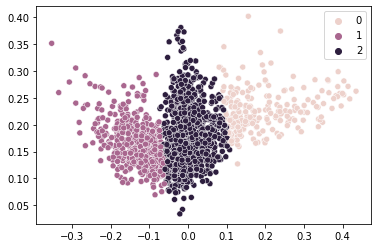

In [ ]:
sns.scatterplot(svd_news_train[:, 1], svd_news_train[:, 0], hue=kmeans.labels_)

### UMAP

In [8]:
umap_news_train = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2,metric='hellinger',random_state=123).fit_transform(news_train)

umap_pre = KMeans(n_clusters = num_cluster,random_state=123).fit(umap_news_train)
score = calinski_harabasz_score(umap_news_train,umap_pre.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(umap_news_train,umap_pre.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(umap_news_train,umap_pre.labels_)
print('Davies-Bouldin Index:',score)

calinski_harabaz：5608.450341
silhouette：0.684158
Davies-Bouldin Index: 0.44931029407203754


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Umap+kmean')

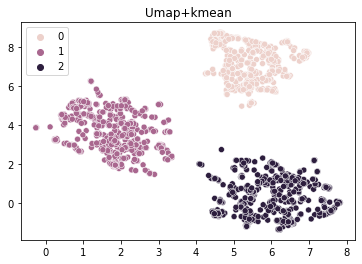

In [9]:
sns.scatterplot(umap_news_train[:, 1], umap_news_train[:, 0], hue=umap_pre.labels_)
plt.title("Umap+kmean")

In [11]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN().fit(umap_news_train)
score = calinski_harabasz_score(umap_news_train,dbscan.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(umap_news_train,dbscan.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(umap_news_train,dbscan.labels_)
print('Davies-Bouldin Index:',score)

calinski_harabaz：2893.466461
silhouette：0.408102
Davies-Bouldin Index: 0.544294799132808


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Umap+DBSCAN')

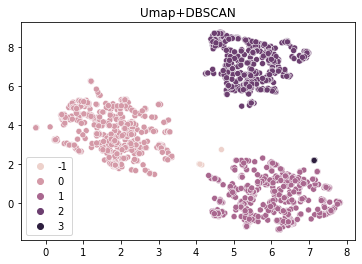

In [12]:
sns.scatterplot(umap_news_train[:, 1], umap_news_train[:, 0], hue=dbscan.labels_)
plt.title("Umap+DBSCAN")

### TSNE

In [ ]:
tsne_news_train = TSNE(n_components=2).fit_transform(news_train)
tsne_pre = KMeans(n_clusters = num_cluster,random_state=123).fit(tsne_news_train)
score = calinski_harabasz_score(tsne_news_train,tsne_pre.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(tsne_news_train,tsne_pre.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(tsne_news_train,tsne_pre.labels_)
print('Davies-Bouldin Index:',score)

calinski_harabaz：2498.521329
silhouette：0.534159
Davies-Bouldin Index: 0.6437797902763658


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


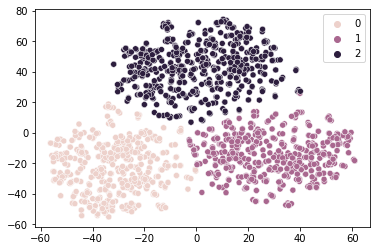

In [ ]:
sns.scatterplot(tsne_news_train[:, 1], tsne_news_train[:, 0], hue=tsne_pre.labels_)

## auto encode

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
inputSize=Input(shape=(5456,))
outputSize=2
encoded = Dense(128, activation='relu')(inputSize)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(outputSize)(encoded)
# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(5456, activation='tanh')(decoded)
# 构建自动编码模型
# 构建自编码模型
autoencoder = Model(inputs=inputSize, outputs=decoded)

# 构建编码模型
encoder = Model(inputs=inputSize, outputs=encoder_output)

# 激活模型
autoencoder.compile(optimizer='adam', loss='mse')

# 训练 非监督学习 经历压缩和解压的自己跟原来的自己比较
autoencoder.fit(news_train.toarray(), news_train.toarray(),epochs=20,batch_size=256,shuffle=True)

In [ ]:
encoded_tf = encoder.predict(news_train.toarray())
kmeans = KMeans(n_clusters = num_cluster,random_state=123).fit(encoded_tf)
score = calinski_harabasz_score(encoded_tf,kmeans.labels_)
print('calinski_harabaz：%f'%(score))
score = silhouette_score(encoded_tf,kmeans.labels_)
print('silhouette：%f' %(score))
score=davies_bouldin_score(encoded_tf,kmeans.labels_)
print('Davies-Bouldin Index:',score)

calinski_harabaz：1063.229851
silhouette：0.352356
Davies-Bouldin Index: 0.9454500754275159


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


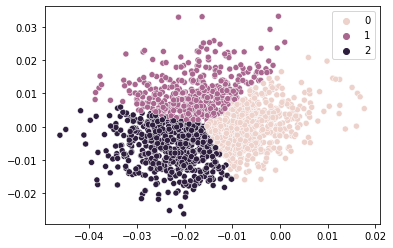

In [ ]:
sns.scatterplot(encoded_tf[:, 0], encoded_tf[:, 1], hue=kmeans.labels_)

# get which part is which

In [ ]:
from collections import Counter
print(Counter(newsgroups_train.target))
print(Counter(umap_pre.labels_))


Counter({1: 593, 2: 546, 0: 480})
Counter({2: 581, 1: 559, 0: 479})


In [ ]:
len(newsgroups_train.target)

1619

In [ ]:
len(umap_pre.labels_)

1619

In [ ]:
summary_res = pd.DataFrame([umap_pre.labels_,newsgroups_train.target]).T

In [ ]:
Counter(summary_res[summary_res[0]==0][1])

Counter({0: 472, 1: 2, 2: 5})

In [ ]:
len(summary_res[summary_res[0]==0])

479

In [ ]:
Counter(summary_res[summary_res[0]==1][1])

Counter({0: 5, 1: 17, 2: 537})

In [ ]:
len(summary_res[summary_res[0]==1])

559

In [ ]:
Counter(summary_res[summary_res[0]==2][1])

Counter({0: 3, 1: 574, 2: 4})

In [ ]:
len(summary_res[summary_res[0]==2])

581

In [ ]:
pickle.dump(umap_pre, open("/content/drive/MyDrive/Colab Notebooks/DM/data/kmean.pkl", "wb"))
kmeans_model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/DM/data/kmean.pkl", "rb"))

# Use kmean predict news type

In [ ]:
raw_text=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DM/data/text.csv")

In [ ]:
raw_text["clean.text"] = raw_text["text"].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z\- \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in nltk.word_tokenize(x) if not i in swords])\
          .apply(lambda x: [SnowballStemmer("english").stem(i) for i in x]
                 )
raw_text["clean.text"]=raw_text["clean.text"].astype(str).tolist()


In [ ]:
raw_text.head()

,case_ID,text,clean.text
0,1781496,"\n\n\n — Shortly after 10 am on September 1st,...","['short', '10', 'septemb', '1st', 'ripley', 'c..."
1,1781509,(SEYMOUR) – The Seymour Police Department prov...,"['seymour', 'seymour', 'polic', 'depart', 'pro..."
2,1781627,"MenuTALLAHASSEE, Fla. (WTXL) — What was once b...","['menutallahasse', 'fla', 'wtxl', 'believ', 'd..."
3,1781631,Police in Newark are investigating a shots fir...,"['polic', 'newark', 'investig', 'shot', 'fire'..."
4,1781809,\nAlready a subscriber? tmp.macro.meter_messag...,"['alreadi', 'subscrib', 'tmp', 'macro', 'meter..."


In [ ]:
raw_train = tfidf_vectorizer.fit_transform(raw_text["clean.text"])
raw_train.shape

(5540, 7901)

In [ ]:
umap_raw_train = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2,metric='hellinger',random_state=123).fit_transform(raw_train)

In [ ]:
raw_train_pred=kmeans_model.fit_predict(umap_raw_train)

In [ ]:
print(Counter(raw_train_pred))

Counter({0: 4943, 1: 452, 2: 145})


In [ ]:
raw_text['class']=raw_train_pred

In [ ]:
raw_text[raw_text['class']!=0]

,case_ID,text,clean.text,class
6,1781832,We've detected that JavaScript is disabled in ...,"['detect', 'javascript', 'disabl', 'browser', ...",1
9,1781965,If you previously used a social network to log...,"['previous', 'use', 'social', 'network', 'logi...",2
14,1782021,We've detected that JavaScript is disabled in ...,"['detect', 'javascript', 'disabl', 'browser', ...",1
16,1782036,URL: https://phl.carto.com/api/v2/sql?q=SELECT...,"['url', 'shoot', 'victim', 'resourc', 'view', ...",2
18,1782041,URL: https://phl.carto.com/api/v2/sql?q=SELECT...,"['url', 'shoot', 'victim', 'resourc', 'view', ...",2
...,...,...,...,...
5513,1857553,We've detected that JavaScript is disabled in ...,"['detect', 'javascript', 'disabl', 'browser', ...",1
5519,1857609,A suspect was in custody Saturday morning afte...,"['suspect', 'custodi', 'saturday', 'morn', 'le...",2
5526,1857703,We've detected that JavaScript is disabled in ...,"['detect', 'javascript', 'disabl', 'browser', ...",1
5531,1857732,We've detected that JavaScript is disabled in ...,"['detect', 'javascript', 'disabl', 'browser', ...",1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


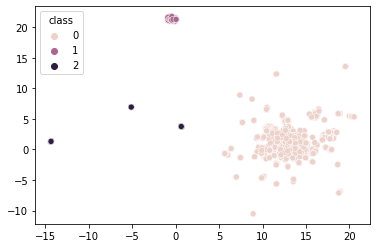

In [ ]:
sns.scatterplot(umap_raw_train[:, 0], umap_raw_train[:, 1], hue=raw_text['class'])